**Importing the dependencies**

In [4]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle

In [5]:

!pip install kaggle

In [6]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:07<00:00, 22.9MB/s]
100% 149M/149M [00:07<00:00, 20.5MB/s]


In [8]:
# conver the zipfolder into files
data="/content/brain-tumor-mri-dataset.zip"

from zipfile import ZipFile

with ZipFile(data,"r") as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [36]:
# Directories for training and testing data
train_dir = '/content/Training/'
test_dir = '/content/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in sorted(os.listdir(train_dir)):  # Sorted for consistency
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in sorted(os.listdir(test_dir)):  # Sorted for consistency
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [37]:
len(train_paths)

5712

In [38]:
len(train_labels)

5712

In [39]:
train_labels.count('pituitary')

1457

In [40]:
train_labels.count('notumor')

1595

In [41]:
train_labels.count('glioma')

1321

In [42]:

train_labels.count('meningioma')

1339

In [43]:
len(test_paths)

1311

In [44]:
len(test_labels)

1311

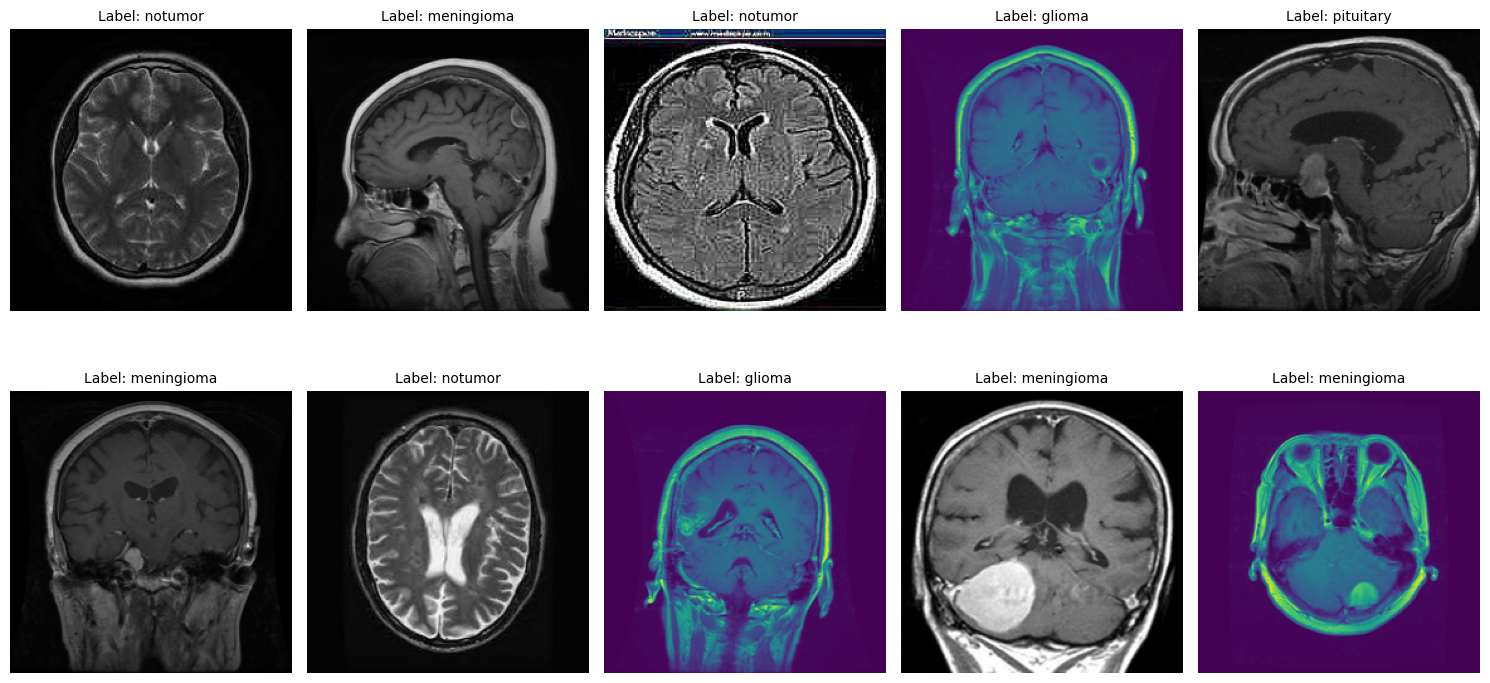

In [45]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [46]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        try:
            image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            image = augment_image(image)
            images.append(image)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))  # Sorted for consistency
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels


In [47]:

# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set specific layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # Input layer
    base_model,  # Add VGG16 base model
    Flatten(),  # Flatten the output of the base model
    Dropout(0.3),  # Dropout layer for regularization
    Dense(128, activation='relu'),  # Dense layer with ReLU activation
    Dropout(0.2),  # Dropout layer for regularization
    Dense(len(sorted(os.listdir(train_dir))), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 20  # Increased for better training

# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=steps
)


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.7234
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - loss: 0.2562 - sparse_categorical_accuracy: 0.9082
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 0.1597 - sparse_categorical_accuracy: 0.9346
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.9611
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 0.0887 - sparse_categorical_accuracy: 0.9685
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 0.0731 - sparse_categorical_accuracy: 0.9689
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9816
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9835
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9846
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━

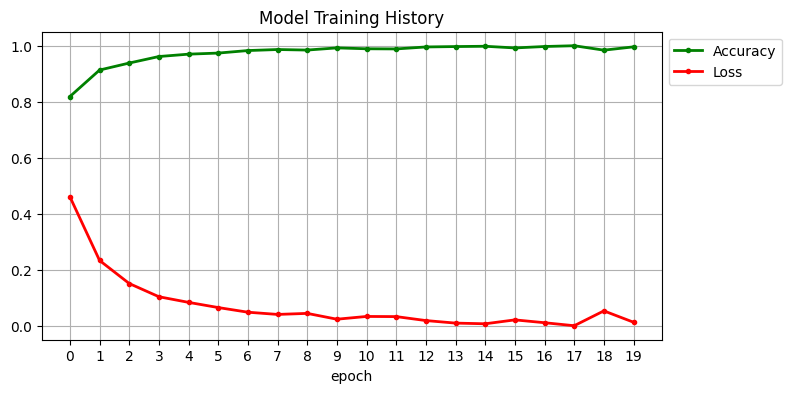

In [48]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# Testing and Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       300
           1       0.96      0.95      0.95       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



Confusion Matrix:
[[289  11   0   0]
 [ 14 291   1   0]
 [  0   0 405   0]
 [  1   2   0 297]]


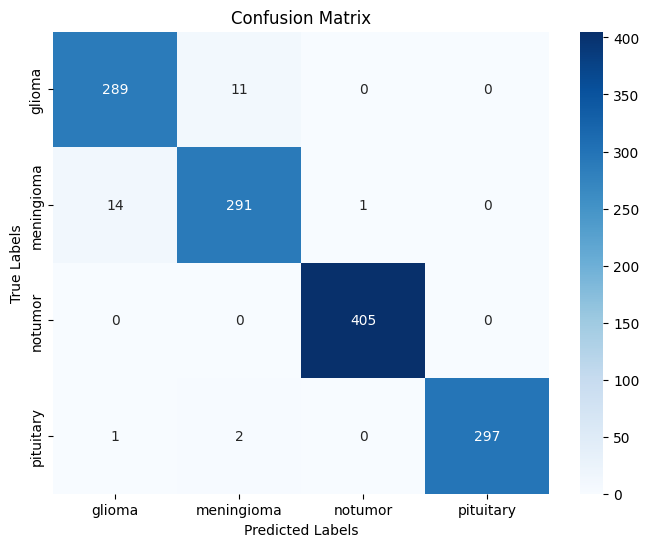

In [50]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(os.listdir(train_dir)),
            yticklabels=sorted(os.listdir(train_dir)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

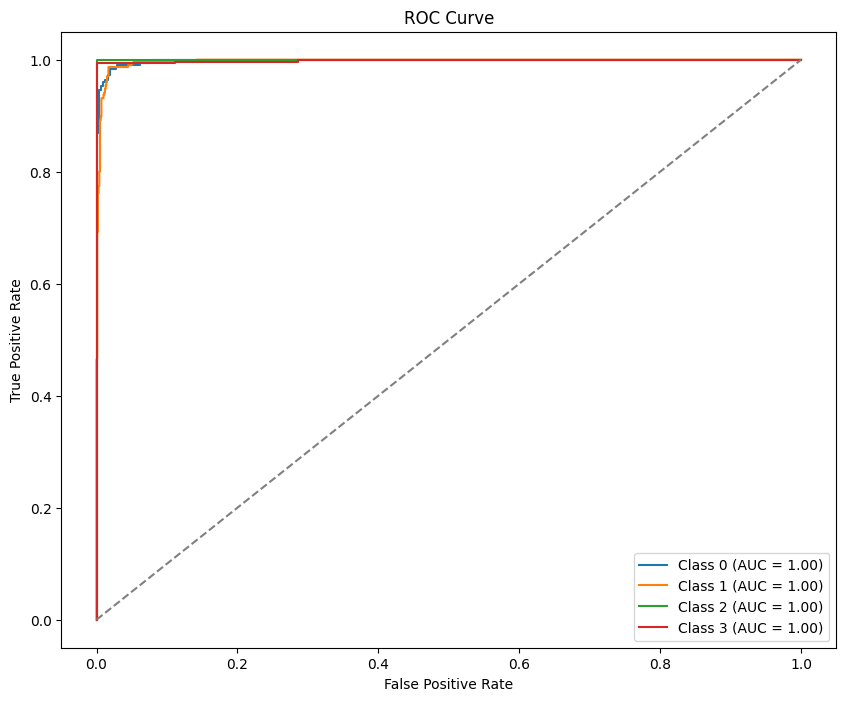

In [51]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [52]:
# Save the entire model
model.save('model.h5')

In [53]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [54]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
# Detection and Display Function
class_labels = sorted(os.listdir(train_dir))

def detect_and_display(img_path, model, image_size=128):
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


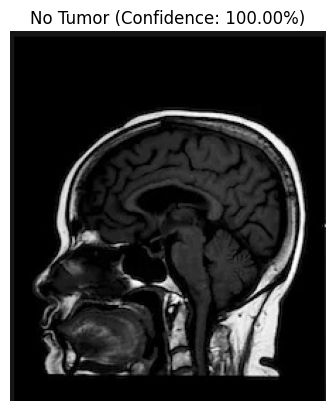

In [55]:
# Example usage
image_path = '/content/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


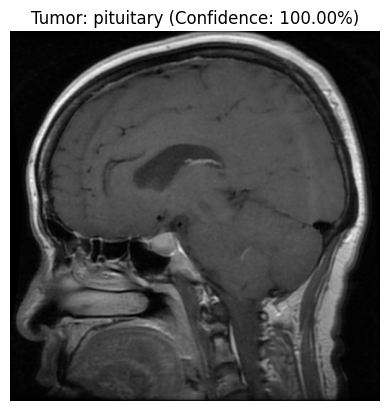

In [56]:
# Example usage
image_path = '/content/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


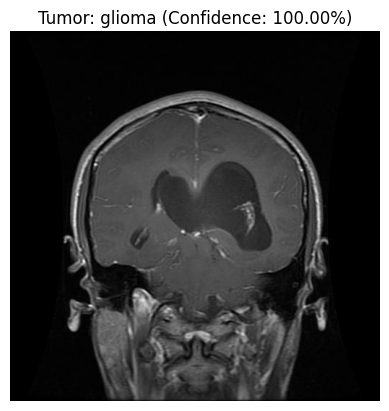

In [57]:
# Example usage
image_path = '/content/Training/glioma/Tr-glTr_0002.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


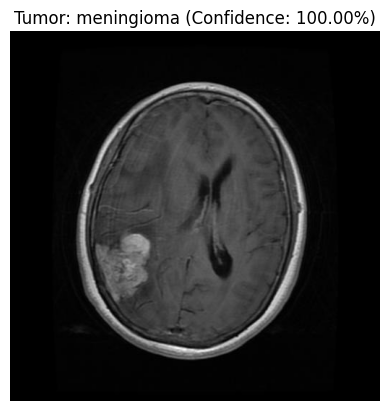

In [58]:
# Example usage
image_path = '/content/Training/meningioma/Tr-meTr_0007.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


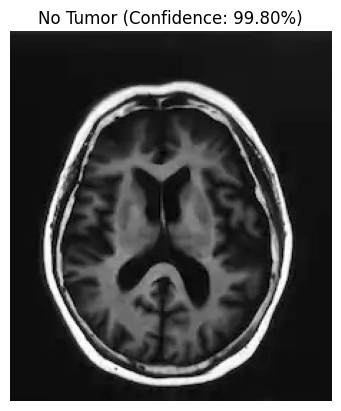

In [59]:
image_path = '/content/Testing/notumor/Te-noTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)